# Defining a dataset
I am using this one https://www.kaggle.com/competitions/it1244-brain-tumor-dataset

In [1]:
import FileIO
include("./data.jl")
include("./transforms.jl")

# create the dataset from all files in a folder, label function gets the last folder in path
ds = DatasetLabeled()

DatasetLabeled(Sample[], Any[])

`data.csv` looks like
```csv
76,benign
77,benign
155,malignant
156,malignant
...
```

In [2]:
path = "D:/datasets/it1244-brain-tumor-dataset/data"

# define the loader
# it reads the file, resizes to 256,256, converts to flux-compatible array and ensures 3 channels
# I had to add `ToChannels(3)` to my loader since most images in the dataset have 3 channels, but a few have 1.
loader = Compose(FileIO.load, Resize(256, 256), to_image_arr, ToChannels(3))

# add all samples
open("$path/train/data.csv") do f
    while !eof(f)
        num, label = split(replace(readline(f), "\ufeff" => ""), ",")
        add_sample!(ds, "$path/train/$num.jpg", loader=loader, label=label)
    end
end

ds.classes

2-element Vector{Any}:
 "benign"
 "malignant"

In [3]:
# show all samples
[i.sample for i in ds.samples][1:4]

4-element Vector{String}:
 "D:/datasets/it1244-brain-tumor-dataset/data/train/17.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/18.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/19.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/20.jpg"

Indexing into a dataset returns a tuple: `(WHC array, one-hot encoded label)`

In [4]:
ds[1]

(Float32[0.0 0.03529412 … 0.007843138 0.007843138; 0.019607844 0.011764706 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.050980393 0.050980393 … 0.047058824 0.047058824;;; 0.16078432 0.20392157 … 0.2 0.2; 0.19607843 0.18039216 … 0.2 0.2; … ; 0.015686275 0.015686275 … 0.023529412 0.023529412; 0.09019608 0.09019608 … 0.09803922 0.09803922;;; 0.42352942 0.4627451 … 0.35686275 0.35686275; 0.42745098 0.4117647 … 0.38431373 0.38431373; … ; 0.0 0.0 … 0.0 0.0; 0.047058824 0.047058824 … 0.03137255 0.03137255], Bool[1, 0])

In [5]:
# size of the image array
size(ds[1][1])

(256, 256, 3)

In [6]:
# one-hot encoded label vector
ds[1][2]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

We can compute the channel-wise mean and standard deviation of the entire dataset using `mean_std`. 

This function supports arbitrary number of dimensions, as long as all samples are channel-last and have the same dimensions and channels.

In [7]:
# Compute mean and std of dataset in 32-element batches for efficiency.
meanstd = mean_std(ds, 16)

([0.24721595548814343, 0.2474578099866067, 0.2478063149798301], [0.2404460431106629, 0.24051943036817736, 0.24072042924742545])

Now we can add a Normalize transform to our dataset using `add_loader!`, which adds a new function to the end of the pipeline.

In [8]:
add_loader!(ds, Normalize(meanstd))
ds.samples[1].loader

Compose((FileIO.load, Resize((256, 256)), to_image_arr, ToChannels(3), Normalize([0.24721595548814343, 0.2474578099866067, 0.2478063149798301], [0.2404460431106629, 0.24051943036817736, 0.24072042924742545])))

Since we don't have a lot of images, we can significantly speed up the training by preloading them all into RAM using `preload!`

In [9]:
    preload!(ds)
    ds[1]

(Float32[-1.0281557 -0.88136965 … -0.9955365 -0.9955365; -0.9466079 -0.97922695 … -1.0281557 -1.0281557; … ; -1.0281557 -1.0281557 … -1.0281557 -1.0281557; -0.8161314 -0.8161314 … -0.832441 -0.832441;;; -0.3603596 -0.18100923 … -0.19731382 -0.19731382; -0.2136184 -0.27883673 … -0.19731382 -0.19731382; … ; -0.9636291 -0.9636291 … -0.93101996 -0.93101996; -0.6538421 -0.6538421 … -0.6212329 -0.6212329;;; 0.72998834 0.892898 … 0.45304188 0.45304188; 0.7462793 0.68111545 … 0.56707865 0.56707865; … ; -1.0294361 -1.0294361 … -1.0294361 -1.0294361; -0.83394456 -0.83394456 … -0.8991084 -0.8991084], Bool[1, 0])

Lets also split into train and test datasets ("test" folder in the dataset is actually a folder with unlabeled samples for submission, so we need to split the "train" folder dataset)

In [10]:
ds_train, ds_test = split_dataset(ds, 0.8)

1, 392
393, 98


2-element Vector{Any}:
 DatasetLabeled(Sample[Sample(Float32[-1.0281557 -1.0281557 … -1.0281557 -1.0281557; -1.0281557 -1.0281557 … -1.0281557 -1.0281557; … ; -1.0281557 -1.0281557 … -1.0281557 -1.0281557; -1.0281557 -1.0281557 … -1.0281557 -1.0281557;;; -1.0288475 -1.0288475 … -1.0288475 -1.0288475; -1.0288475 -1.0288475 … -1.0288475 -1.0288475; … ; -1.0288475 -1.0288475 … -1.0288475 -1.0288475; -1.0288475 -1.0288475 … -1.0288475 -1.0288475;;; -1.0294361 -1.0294361 … -1.0294361 -1.0294361; -1.0294361 -1.0294361 … -1.0294361 -1.0294361; … ; -1.0294361 -1.0294361 … -1.0294361 -1.0294361; -1.0294361 -1.0294361 … -1.0294361 -1.0294361], identity, identity, "benign"), Sample(Float32[-1.0118461 -1.0118461 … -0.84875053 1.6466119; -1.0118461 -1.0118461 … -0.9302983 1.6466119; … ; -1.0118461 -1.0118461 … -0.8976792 1.6466119; -1.0118461 -1.0118461 … -0.88136965 1.6466119;;; -0.8984108 -0.9147154 … -0.8494971 1.6451039; -0.8984108 -0.9147154 … -0.93101996 1.6451039; … ; -0.8984108 -0.9147154 …

Now we can create a DataLoader using MLUtils. Make sure to specify `collate = true`.

In [11]:
import MLUtils
dl_train = MLUtils.DataLoader(ds_train, batchsize=16, shuffle=true, collate=true)
dl_test = MLUtils.DataLoader(ds_test, batchsize=16, shuffle=false, collate=true)

7-element DataLoader(::DatasetLabeled, batchsize=16, collate=Val{true}())
  with first element:
  (256×256×3×16 Array{Float32, 4}, 2×16 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

Thats it! Time to use flux, so I defined simple CNN model (and did zero optimal architecture search for this as its a demo).

In [12]:
using Flux, CUDA, Statistics, ProgressMeter
model = Chain(
    Conv((5, 5), 3 => 16, relu), # 254?
    MaxPool((3, 3)), # 84?
    Conv((3, 3), 16 => 32, relu), # 82?
    MaxPool((2, 2)), # 41?
    Conv((3, 3), 32 => 48, relu), #39?
    MaxPool((2, 2)), # 19?
    Conv((3, 3), 48 => 64, relu), #17?
    MaxPool((2, 2)), # 8?
    Conv((3, 3), 64 => 32, relu), # 6?
    Flux.flatten,
    Dense(32 * 6 * 6, length(ds.classes)),
) |> gpu

# pass one batch through it
batch = first(dl_train)
out1 = model(batch[1] |> gpu) |> cpu

2×16 Matrix{Float32}:
 -0.260727  -0.227217  -0.180032  …  -0.35198   -0.151645  -0.523062
  0.158869   0.527468   0.223632      0.654291  -0.138552   0.481076

And the training loop is copy-pasted from Flux docs, but I added testing on dl_test and accuracy

In [13]:
# Standard training loop works with our dataset out of the box
losses = []
accuracy = []
test_accuracy = []
optim = Flux.setup(Flux.Adam(1e-3), model)
@showprogress for epoch in 1:10

    # train
    for (images, labels) in dl_train
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(images |> gpu)
            # Calculate accuracy
            Flux.ignore_derivatives() do
                push!(accuracy, mean(argmax(y_hat |> cpu, dims=1) .== argmax(labels, dims=1)))
            end
            Flux.logitcrossentropy(y_hat, labels |> gpu)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)
    end

    #test
    test_accuracy_epoch = []
    for (images, labels) in dl_test
        y_hat = model(images |> gpu)
        push!(test_accuracy_epoch, mean(argmax(y_hat |> cpu, dims=1) .== argmax(labels, dims=1)))
    end
    push!(test_accuracy, mean(test_accuracy_epoch))

end

# pass one batch through the trained model
out1 = model(batch[1] |> gpu) |> cpu

Progress:  20%|█████████                                |  ETA: 0:07:59

Progress:  30%|█████████████                            |  ETA: 0:05:39

Progress:  40%|█████████████████                        |  ETA: 0:04:22

Progress:  50%|█████████████████████                    |  ETA: 0:03:18

Progress:  60%|█████████████████████████                |  ETA: 0:02:33

Progress:  70%|█████████████████████████████            |  ETA: 0:01:51

Progress:  80%|█████████████████████████████████        |  ETA: 0:01:11

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:35

Progress: 100%|█████████████████████████████████████████| Time: 0:05:49


2×16 Matrix{Float32}:
  3.90389  -0.941904   4.86953   2.57668  …  -2.93011  0.595962  -1.35889
 -1.4793    1.70269   -2.52506  -1.92854      4.28724  2.791      2.25266

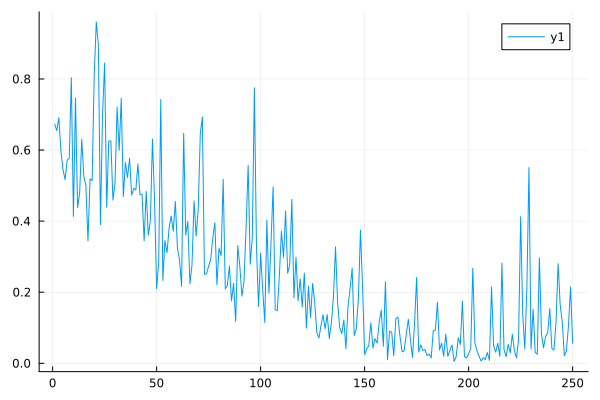

In [14]:
using Plots
plot(losses)

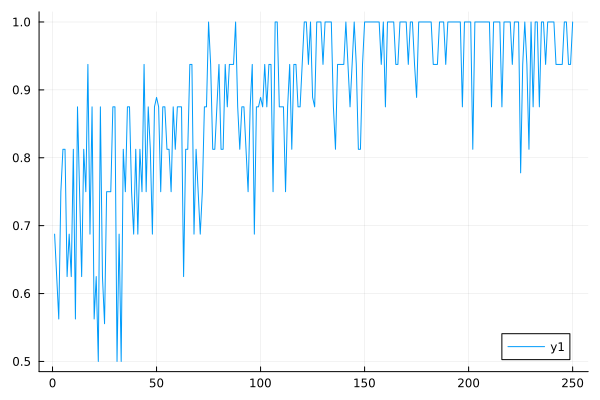

In [15]:
plot(accuracy)

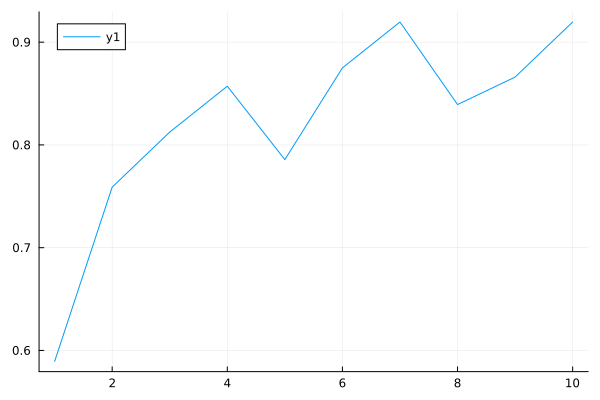

In [16]:
plot(test_accuracy)